# Week 2: Geostrophy and thermal wind balance
*MAQ - 32806, Chiel van Heerwaarden & Imme Benedict, 2017*

In this assignment you will investigate whether the large-scale flow is in geostrophic and thermal wind balance. For this, you will use ECMWF ERA-Interim data from the 1st of January 2016 3:00.
___

# Setting up Python and loading the data
We start the tutorial by loading the required Python packages and setting the figure properties.

In [2]:
# Loading the packages.
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import matplotlib.pyplot as plt # Matplotlib is a scientific plotting package.
import datetime                 # Datetime is a package to deal with dates.
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import LinearSegmentedColormap

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline
plt.rcParams.update({'font.size': 11})          # Set the standard font size of the plots to 11pt.
plt.rcParams.update({'figure.figsize': [13,5]}) # Set the standard figure size.

In [3]:
# Create custom color map similar to the NCAR NCL WhiteBlueGreenYellowRed
cdict = {'red':   ((   0/253., 255./255., 255./255.),
                   (  36/253., 157./255., 157./255.),
                   (  72/253.,  72./255.,  72./255.),
                   ( 108/253.,  73./255.,  73./255.),
                   ( 145/253., 250./255., 250./255.),
                   ( 181/253., 245./255., 245./255.),
                   ( 217/253., 211./255., 211./255.),
                   ( 253/253., 146./255., 146./255.)),
         'green': ((   0/253., 255./255., 255./255.),
                   (  36/253., 218./255., 218./255.),
                   (  72/253., 142./255., 142./255.),
                   ( 108/253., 181./255., 181./255.),
                   ( 145/253., 232./255., 232./255.),
                   ( 181/253., 106./255., 106./255.),
                   ( 217/253.,  31./255.,  31./255.),
                   ( 253/253.,  21./255.,  21./255.)),
         'blue':  ((   0/253., 255./255., 255./255.),
                   (  36/253., 247./255., 247./255.),
                   (  72/253., 202./255., 202./255.),
                   ( 108/253.,  70./255.,  70./255.),
                   ( 145/253.,  92./255.,  92./255.),
                   ( 181/253.,  45./255.,  45./255.),
                   ( 217/253.,  40./255.,  40./255.),
                   ( 253/253.,  25./255.,  25./255.))}

my_cmap = LinearSegmentedColormap('my_colormap', cdict,256)

___
Now, you load the data and read out the desired variables from a NetCDF file from the ECMWF ERA-Interim data archive. You are loading a file with data from 1 January 2016.

In [4]:
# Loading the ERA data.
nc_file = nc.Dataset("era5_data.nc", "r")
lat = nc_file.variables["latitude"][:]
lon = nc_file.variables["longitude"][:]
p = nc_file.variables["level"][:]*100.
t = 0
time = nc.num2date(nc_file.variables["time"][t], nc_file.variables["time"].units)
print("The time is: {}".format(time))

# With the code below, we roll the map, to get the 0 meridian,
# rather than the Pacific in the middle.
nroll = lon.size//2
lon = np.roll(lon, nroll)
lon = np.where(lon>=180., lon-360., lon)

# We load 3D fields of the two horizontal wind components, the geopotential and the temperature.
u     = np.roll(nc_file.variables["u"][t,:,:,:], nroll, -1)
v     = np.roll(nc_file.variables["v"][t,:,:,:], nroll, -1)
Phi   = np.roll(nc_file.variables["z"][t,:,:,:], nroll, -1)
T     = np.roll(nc_file.variables["t"][t,:,:,:], nroll, -1)

nc_file.close() # The file access is closed as no further data is needed now.

The time is: 2016-01-01 00:00:00


In [5]:
lon_start = -80.
lon_end   =  80.
lat_start =  5.
lat_end   =  75.

___
# Plotting the temperature and geopotential on a map
As a starting point you find below the temperature and geopotential at 500 hPa.

In [6]:
omega = 7.292e-5
a_earth = 6.37e6
g = 9.81
R = 287.

In [14]:
# Two arrays of zeros are initialized with the same shape as that of Z.
dPhidx = np.zeros(Phi.shape)
dPhidy = np.zeros(Phi.shape)

latrad = np.deg2rad(lat)
lonrad = np.deg2rad(lon)

# We initialize an array with the cosine of the latitude.
cos_lat = np.cos(latrad)

# With \ it is possible to break a long line. Carefully study the use of the newaxis keyword.
dTdx = (a_earth*cos_lat[np.newaxis,:,np.newaxis])**(-1) \
     * np.gradient(Phi, axis=2) / np.gradient(lonrad[np.newaxis, np.newaxis, :], axis=2)
dTdy = (a_earth)**(-1) \
     * np.gradient(Phi, axis=1) / np.gradient(latrad[np.newaxis, :, np.newaxis], axis=1)

V = (u**2 + v**2)**.5
dT = (dTdx**2 + dTdy**2)**.5

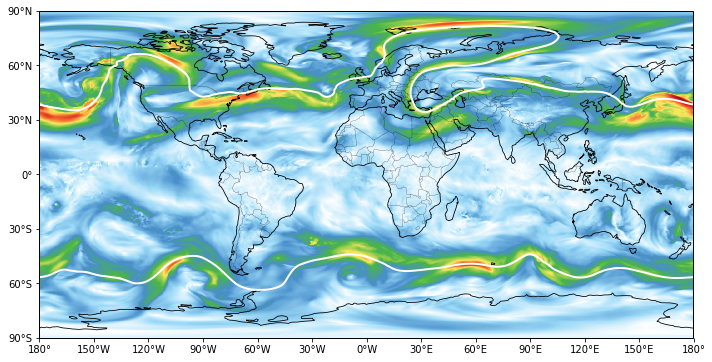

In [45]:
p_plot = 50000.
n = abs(p-p_plot).argmin()
n200 = abs(p-20000).argmin()

my_projection = ccrs.PlateCarree(central_longitude=0)

fig1 = plt.figure(figsize=(10,6))
ax1 = plt.subplot(111, projection=my_projection)

ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

Phi_range = np.array([-1e8, 53000, 1e8])
cb = ax1.pcolormesh(lon, lat, V[n,:,:], cmap=my_cmap)
#fig1.colorbar(cb)
cz = ax1.contour(lon, lat, Phi[n,:,:], Phi_range,
                 colors='w', linestyles='-', linewidths=2) # We plot the geopotential in contours.
#ax1.clabel(cz, fmt='%1.0f', fontsize=10.) # We add labels to the contour lines.
fig1.tight_layout() # With this function we make the figure fit as good as possible.


In [46]:
lines = cz.allsegs[:]

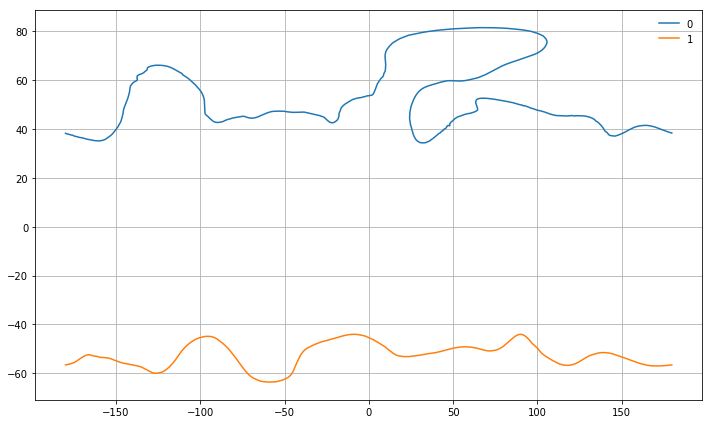

In [47]:
plt.figure(figsize=(10,6))
nl = 0
for l in lines[0]:
    plt.plot(*l.T, '-', label='{}'.format(nl))
    nl += 1
plt.legend(loc=0, frameon=False)
plt.grid()
plt.tight_layout()

In [28]:
import haversine as hv
for l in lines[0]:
    total_length = 0.
    for i in range(l.shape[0]):
        length = hv.haversine(l[i], l[i-1])
        total_length += length
    print(total_length)

64154.77450805144
41049.99861264661


In [39]:
lines_5 = lines.copy()

In [40]:
lines_5

[[array([[-180.        ,   38.28987743],
         [-179.88701394,   38.25      ],
         [-179.75      ,   38.19519442],
         ..., 
         [ 179.25      ,   38.49599535],
         [ 179.5       ,   38.43693626],
         [ 179.75      ,   38.36340684]]),
  array([[ 179.75      ,  -56.64279164],
         [ 179.5       ,  -56.66779164],
         [ 179.25      ,  -56.67526512],
         ..., 
         [-179.5       ,  -56.56779164],
         [-179.75      ,  -56.59279164],
         [-180.        ,  -56.61779164]])]]